#### Overview
- Reproducing https://medium.com/@dave.cote.msc/hybrid-multimodal-neural-network-architecture-combination-of-tabular-textual-and-image-inputs-7460a4f82a2e
- This script inspects the datasets (tabular and images)

In [1]:
#Libraries
import numpy as np
import pandas as pd
import os 

#Change working directory
os.chdir("/workspaces/deeplearning-multimodal-neural-network")

In [10]:
#Import tabular dataset and a brief inspection
df_dataset = pd.read_csv('data/austinHousingData.csv')
print(df_dataset.shape)
print(df_dataset.head(3))
print(list(df_dataset.columns), )

(15171, 47)
         zpid          city         streetAddress  zipcode  \
0   111373431  pflugerville  14424 Lake Victor Dr    78660   
1   120900430  pflugerville    1104 Strickling Dr    78660   
2  2084491383  pflugerville   1408 Fort Dessau Rd    78660   

                                         description   latitude  longitude  \
0  14424 Lake Victor Dr, Pflugerville, TX 78660 i...  30.430632 -97.663078   
1  Absolutely GORGEOUS 4 Bedroom home with 2 full...  30.432673 -97.661697   
2  Under construction - estimated completion in A...  30.409748 -97.639771   

   propertyTaxRate  garageSpaces  hasAssociation  ...  numOfMiddleSchools  \
0             1.98             2            True  ...                   1   
1             1.98             2            True  ...                   1   
2             1.98             0            True  ...                   1   

   numOfHighSchools  avgSchoolDistance  avgSchoolRating  avgSchoolSize  \
0                 1           1.266667     

### Tabular Data Engineering
Following the reference (see link in the first cell), the following data transformations are performed:

Features
- 'numOfBathrooms': if zero and if 'yearBuilt' is earlier than 1989 inclusive, then become 1; if zero and if 'yearBuilt' is later than 1989, then become 2
- 'numOfBedrooms': if zero and if 'yearBuilt' is earlier than 1989 inclusive, then become 2; if zero and if 'yearBuilt' is later than 1989, then become 2.5
- 'garageSpaces': if more than 3, then become 3
- 'parkingSpaces': if more than 3, then become 3
- 'lotSizeSqFt': delete outliers (>IQR * 1.6, < IQR * 1.6)
- 'livingAreaSqFt': delete outliers (>IQR * 1.6, < IQR * 1.6)
- 'latitude': delete outliers (< 30.12)
- 'zipcode': delete non-Austin zipcode
- 'numOfAccessibilityFeatures': Two-class binary (No: 0; Few: 1)
- 'numOfPatioAndPorchFeatures': Two-class binary (No: 0; Few: 1)
- 'numOfSecurityFeatures': Two-class binary (No: 0; Few: 1)
- 'numOfWaterfrontFeatures': Two-class binary (No: 0; Few: 1)
- 'numOfWindowFeatures': Two-class binary (No: 0; Few: 1)
- 'numOfCommunityFeatures': Two-class binary (No: 0; Few: 1)


Target
- 'latestPrice': Adjust past price with inflation (concept drift)

Opportunities (further processing)
- 'longitude' and 'latitude': KMeans clustering (n=25) for geospatial clusters

Opportunities (excluded for now)
- 'description' -  dirty text descriptions (normalization, stop words, lemmatization)
- 'zipcode' - map census data (crime_reports, median_household, etc)

Unused
- 'homeImage' is not used in tabular ML
- 'zpid' is not used 

Let's inspect these columns:

In [7]:
#More inspection 
print('target column')
print(df_dataset['latestPrice'].head())

print('not used in tabular ML')
print(df_dataset['homeImage'].head())
print(df_dataset['description'].head())
print(df_dataset['zpid'].head())


target column
0    305000.0
1    295000.0
2    256125.0
3    240000.0
4    239900.0
Name: latestPrice, dtype: float64
not used in tabular ML
0    111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f...
1    120900430_8255c127be8dcf0a1a18b7563d987088-p_f...
2    2084491383_a2ad649e1a7a098111dcea084a11c855-p_...
3    120901374_b469367a619da85b1f5ceb69b675d88e-p_f...
4    60134862_b1a48a3df3f111e005bb913873e98ce2-p_f.jpg
Name: homeImage, dtype: object
0    14424 Lake Victor Dr, Pflugerville, TX 78660 i...
1    Absolutely GORGEOUS 4 Bedroom home with 2 full...
2    Under construction - estimated completion in A...
3    Absolutely darling one story home in charming ...
4    Brimming with appeal & warm livability! Sleek ...
Name: description, dtype: object
0     111373431
1     120900430
2    2084491383
3     120901374
4      60134862
Name: zpid, dtype: int64


In [58]:
#Basic data preprocessing
df_processed=df_dataset.copy()

#Check dimension 
print(df_processed.shape)

#Check datatype for each columns
print(df_processed.dtypes)

#Check which column has null value
nullseries = df_processed.isnull().sum()
print(nullseries[nullseries > 0])

(15171, 47)
zpid                            int64
city                           object
streetAddress                  object
zipcode                         int64
description                    object
latitude                      float64
longitude                     float64
propertyTaxRate               float64
garageSpaces                    int64
hasAssociation                   bool
hasCooling                       bool
hasGarage                        bool
hasHeating                       bool
hasSpa                           bool
hasView                          bool
homeType                       object
parkingSpaces                   int64
yearBuilt                       int64
latestPrice                   float64
numPriceChanges                 int64
latest_saledate                object
latest_salemonth                int64
latest_saleyear                 int64
latestPriceSource              object
numOfPhotos                     int64
numOfAccessibilityFeatures      int64


Only 'description' has 2 null values. Since 'description' will not be used in this instance, we won't transform the column now.

In [59]:
#Basic data preprocessing.
# - 'numOfBathrooms': if zero and if 'yearBuilt' is earlier than 1989 inclusive, then become 1; if zero and if 'yearBuilt' is later than 1989, then become 2
df_processed.loc[(df_processed['numOfBathrooms']==0)& (df_processed['yearBuilt'] > 1989), 'numOfBathrooms'] = 2
df_processed.loc[(df_processed['numOfBathrooms']==0)& (df_processed['yearBuilt'] <= 1989), 'numOfBathrooms'] = 1

# - 'numOfBedrooms': if zero and if 'yearBuilt' is earlier than 1989 inclusive, then become 2; if zero and if 'yearBuilt' is later than 1989, then become 2.5
df_processed.loc[(df_processed['numOfBedrooms']==0)& (df_processed['yearBuilt'] > 1989), 'numOfBedrooms'] = 2
df_processed.loc[(df_processed['numOfBedrooms']==0)& (df_processed['yearBuilt'] <= 1989), 'numOfBedrooms'] = 1

# - 'garageSpaces': if more than 3, then become 3
df_processed.loc[(df_processed['garageSpaces']> 3), 'garageSpaces'] = 3

# - 'parkingSpaces': if more than 3, then become 3
df_processed.loc[(df_processed['parkingSpaces']> 3), 'parkingSpaces'] = 3

# - 'lotSizeSqFt': delete outliers (>IQR * 1.6, < IQR * 1.6)
# Computing IQR
Q1 = df_processed['lotSizeSqFt'].quantile(0.25)
Q3 = df_processed['lotSizeSqFt'].quantile(0.75)
IQR = Q3 - Q1
# delete outliers
df_processed = df_processed.query('(@Q1 - 1.5 * @IQR) <= lotSizeSqFt <= (@Q3 + 1.5 * @IQR)')

#Check dimension 
print("After processing lotSizeSqFt: " + str(df_processed.shape))


# - 'livingAreaSqFt': delete outliers (>IQR * 1.6, < IQR * 1.6)
# Computing IQR
Q1 = df_processed['livingAreaSqFt'].quantile(0.25)
Q3 = df_processed['livingAreaSqFt'].quantile(0.75)
IQR = Q3 - Q1
# delete outliers
df_processed = df_processed.query('(@Q1 - 1.5 * @IQR) <= livingAreaSqFt <= (@Q3 + 1.5 * @IQR)')

#Check dimension 
print("After processing livingAreaSqFt: " + str(df_processed.shape))

# - 'latitude': delete outliers (< 30.12)
# delete outliers
df_processed = df_processed.query('latitude > 30.12')

#Check dimension 
print("After processing latitude: " + str(df_processed.shape))

# - 'zipcode': delete non-Austin zipcode
# - 'numOfAccessibilityFeatures': Two-class binary (No: 0; Few: 1)
df_processed.loc[df_processed["numOfAccessibilityFeatures"] > 0, "numOfAccessibilityFeatures"] = 1

# - 'numOfPatioAndPorchFeatures': Two-class binary (No: 0; Few: 1)
df_processed.loc[df_processed["numOfPatioAndPorchFeatures"] > 0, "numOfPatioAndPorchFeatures"] = 1

# - 'numOfSecurityFeatures': Two-class binary (No: 0; Few: 1)
df_processed.loc[df_processed["numOfSecurityFeatures"] > 0, "numOfSecurityFeatures"] = 1

# - 'numOfWaterfrontFeatures': Two-class binary (No: 0; Few: 1)
df_processed.loc[df_processed["numOfWaterfrontFeatures"] > 0, "numOfWaterfrontFeatures"] = 1

# - 'numOfWindowFeatures': Two-class binary (No: 0; Few: 1)
df_processed.loc[df_processed["numOfWindowFeatures"] > 0, "numOfWindowFeatures"] = 1

# - 'numOfCommunityFeatures': Two-class binary (No: 0; Few: 1)
df_processed.loc[df_processed["numOfCommunityFeatures"] > 0, "numOfCommunityFeatures"] = 1

After processing lotSizeSqFt: (13855, 47)
After processing livingAreaSqFt: (13611, 47)
After processing latitude: (13611, 47)


Opportunities (further processing)
- 'longitude' and 'latitude': KMeans clustering (n=25) for geospatial clusters
- " We can see that there are some zipcode clusters where the price is higher (red) than other regions (blue). I’ve created a new feature that represent the zipcode clusters called regionCluster using the kmeans algorithm:" 

In [61]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=25, random_state=0, n_init='auto').fit(df_processed[['longitude', 'latitude']])
df_processed['regionCluster'] = kmeans.predict(df_processed[['longitude', 'latitude']])


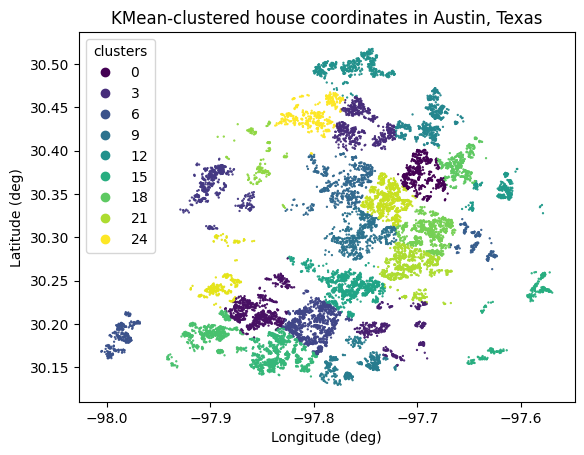

In [73]:
import matplotlib.pyplot as plt

#Visualize clusters
fig, ax = plt.subplots()
p_scatter = ax.scatter(df_processed['longitude'], df_processed['latitude'], c=df_processed['regionCluster'].astype(float), s=0.4)
plt.title("KMean-clustered house coordinates in Austin, Texas")
plt.xlabel("Longitude (deg)")
plt.ylabel("Latitude (deg)")
ax.legend(*p_scatter.legend_elements(), title='clusters')

plt.show()

Target
- 'latestPrice': Adjust past price with inflation (concept drift)
Target inflation adjustment
https://data.austintexas.gov/browse